In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from autorank import autorank, create_report, plot_stats
from sklearn.metrics import accuracy_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import SelectFromModel

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
RANDOM_STATE = 1234 
np.random.seed(RANDOM_STATE)

data = pd.read_csv("data_A2.csv", header=None)
label = pd.read_csv("labels_A2.csv", header=None)
label = label.astype("int")

X = data.to_numpy()
y = label.to_numpy()

# Task 1 [Imputating NaN]

Using the boxplot to check preliminary observations of the dataset, we can see (mostly) every feature has outliers present. This suggests imputation with the median as the mean is influenced by outliers. We will take this into consideration when implementing the IterativeImputer. 

The IterativeImputer is a multivariate imputer technique for replacing missing values. IterativeImputer first imputes the missing value based on the initial strategy parameter (initial_strategy="median") and then trains an estimator (default=BayesianRidge) to model a feature based on the the other features in a round-robin fashion for a total of max_inter=10 imputation rounds. Since our dataset contains a sizeable number of observations, IterativeImputer's estimator will fit better, and thus be more robust. Compared to SimpleImputer, this introduces variability in the range of possible imputed data and is common practice in the statistics community to prefer multiple imputation over single imputation.   

Note: Although it is good practice to seperate the data into training and test sets before imputation of missing values, such that the information from the test set doesn't influence the training set and vice versa, we will ignore the best practices for the following assignment. 


(1000, 100)


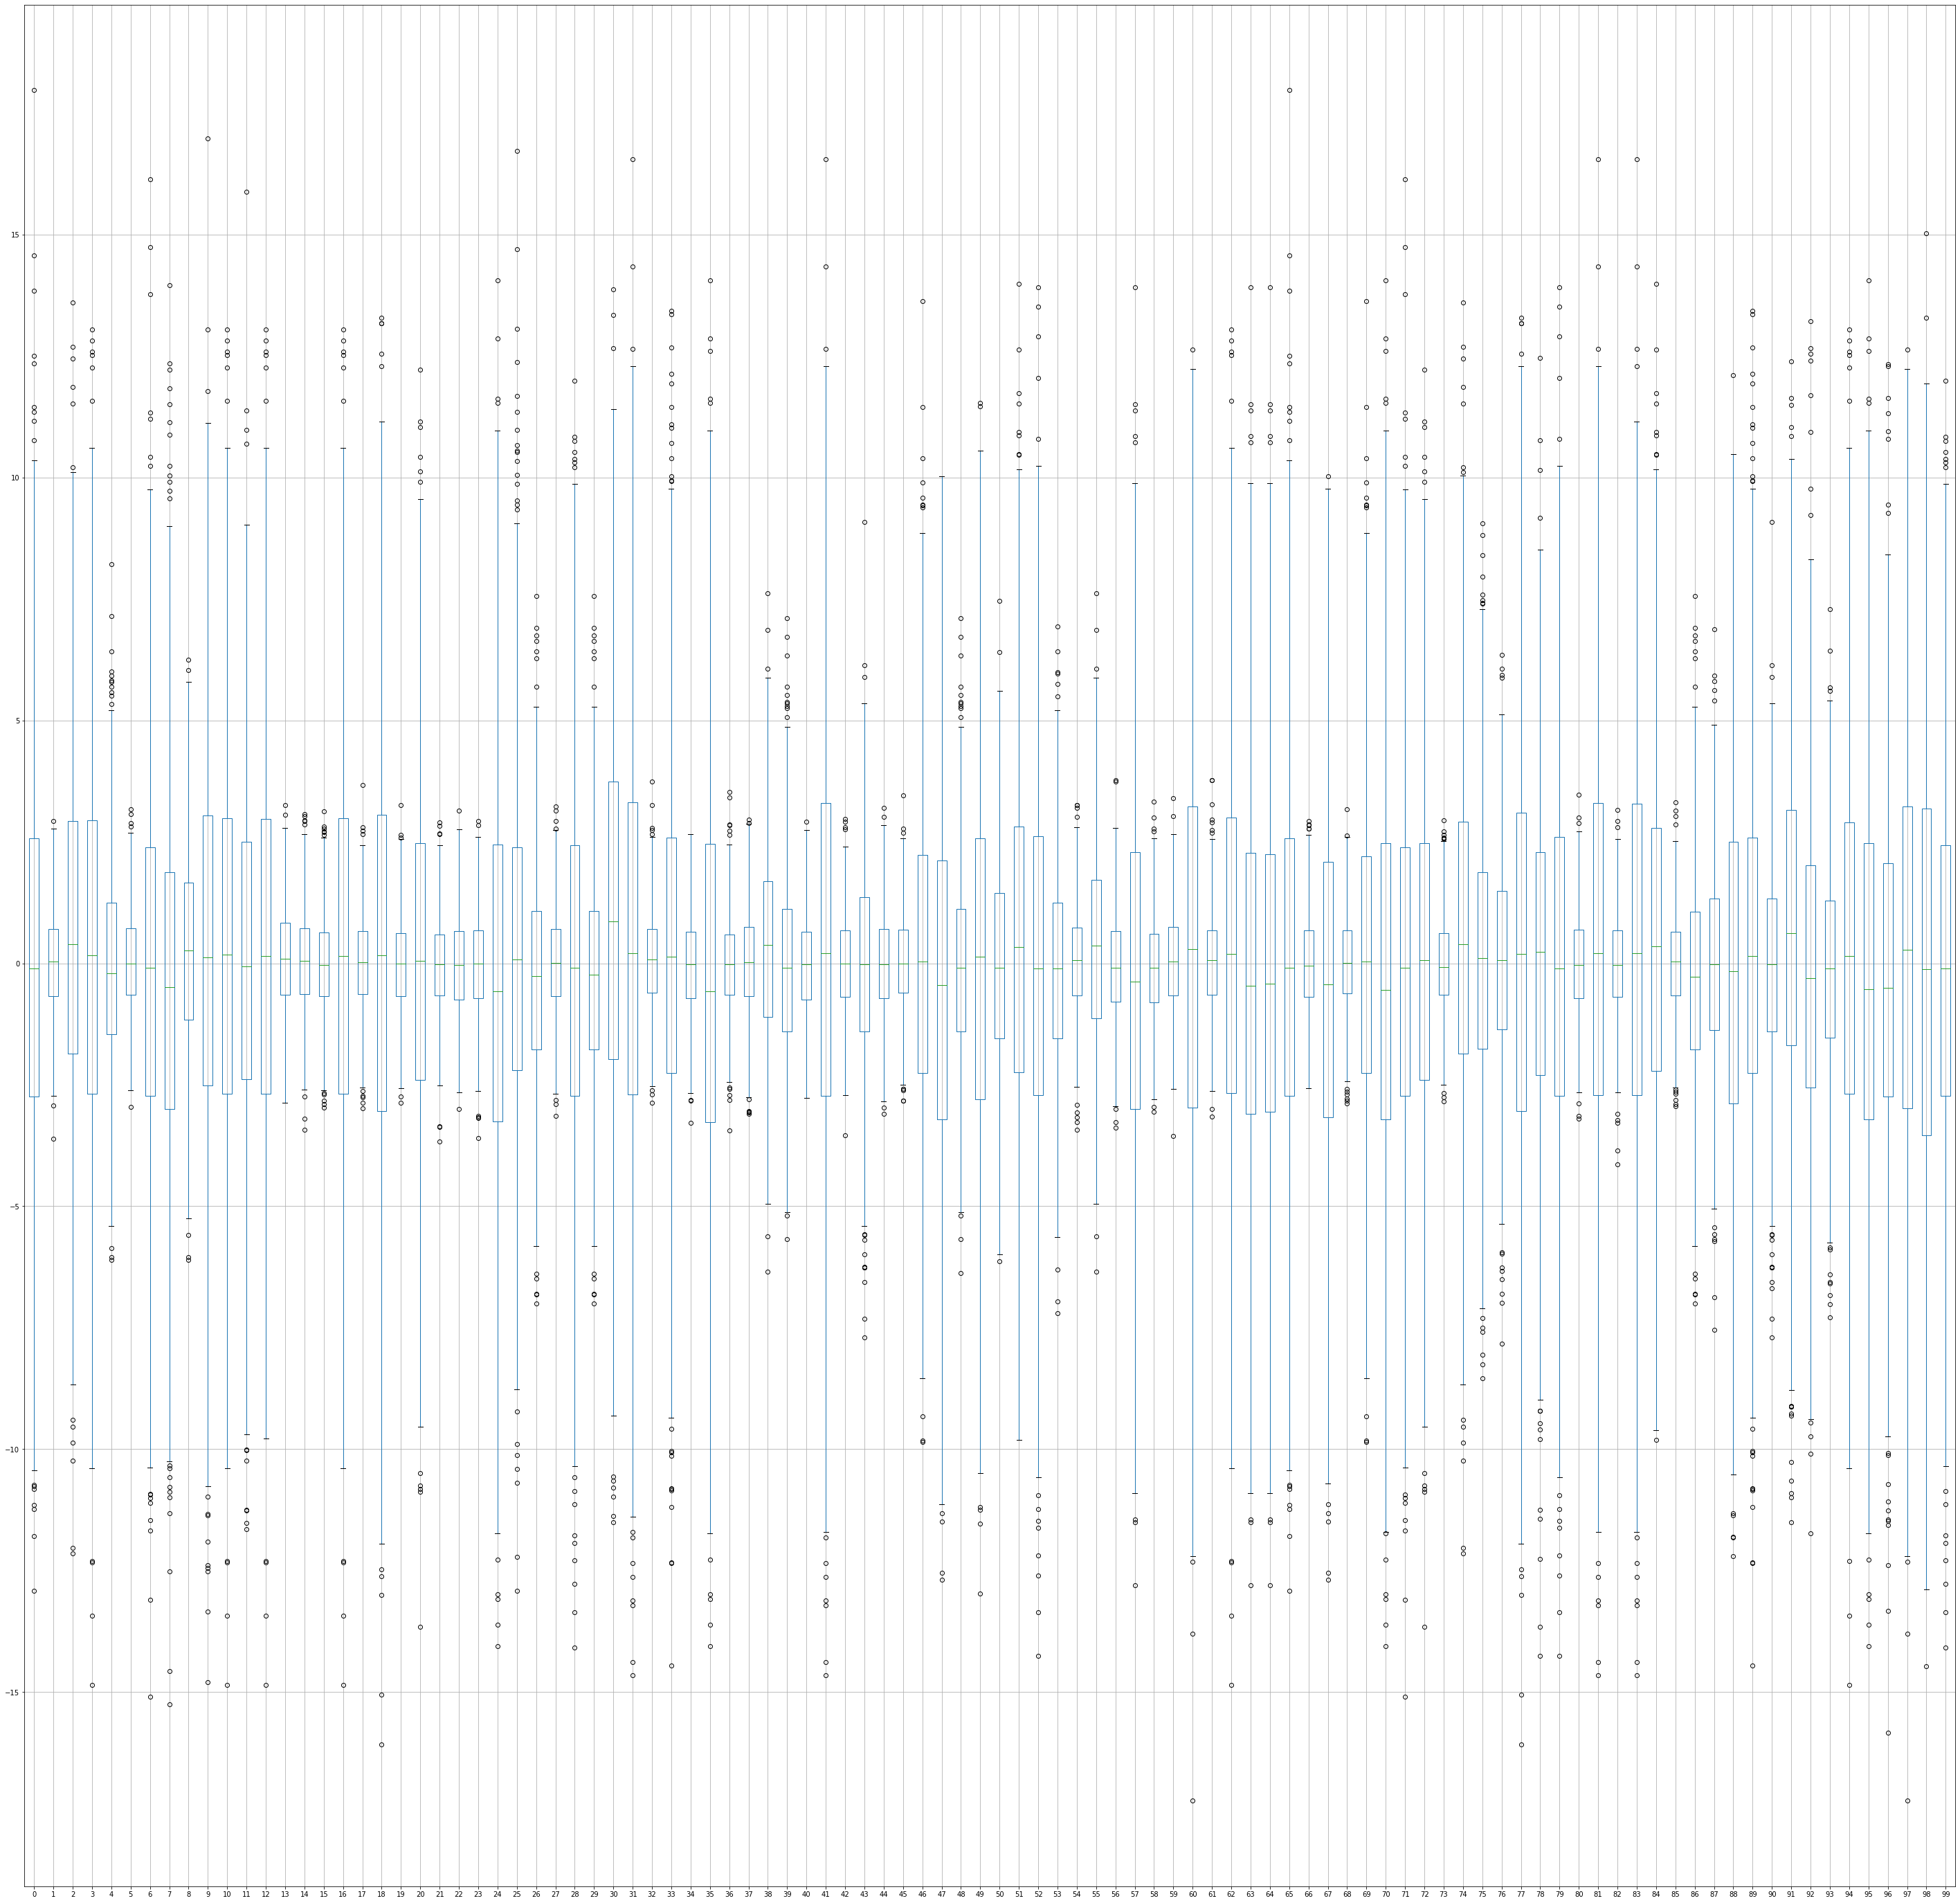

In [4]:
data.boxplot(figsize=(50, 50))

imputer = IterativeImputer(missing_values=np.nan, max_iter=10, initial_strategy='median', random_state=RANDOM_STATE)
imputer.fit(X, y)
X = imputer.transform(X)
print(X.shape)


# Task 2 [Determining top 10 features] 

We use the feature selection SelectFromModel meta-transformer to determine the top 10 features in predicting the response. SelectFromModel can be used in conjunction with a tree-based estimator (in this case, we use RandomForest) to discard irrelevant features below a certain threshold value. The importance of a feature is computed from the mean decrease in the Gini impurity achieved by splitting of the respective feature in which a higher impurity value  


In [5]:
selector = SelectFromModel(estimator=RandomForestClassifier(), max_features=10).fit(X, y.ravel())
X = selector.fit_transform(X, y.ravel())
print(X.shape)


(1000, 10)


# Task 3 [Results] 

Decision Tree train accuracy: 100.00%  
Decision Stump train accuracy: 61.60%  
Random Forest train accuracy: 100.00%  
Pruned Decision Tree train accuracy: 87.57%  
  
Decision Tree test accuracy: 62.53%  with standard deviation of 3.29%  
Decision Stump test accuracy: 60.78% with standard of deviation of 3.37%  
Random Forest test accuracy: 70.02% with standard deviation of 2.63%  
Pruned Decision Tree test accuracy: 63.35% with standard deivation of 3.09% 

Decision stumps have the lowest variance between the training accuracy (61.60%) and testing accuracy (60.78%) which indicates underfitting and high bias towards misclassifications. Decision stumps perform the worst because the shallow depth of a single split doesn't have the complexity to accurately capture the relationship between the features and the response. 

On the other hand, decision trees are prone to overfitting when allowed to grow with no restrictions and thus learn rules of a training set to a point of high granularity which impacts the predictive accuracy of new data. Therefore, standard decision trees will always have a training set accuracy of 100% and have high variance compared to the test set accuracy of 62.53%. Pruning is a technique that compresses the size of decision trees by removing nodes that do not have high predictive power for classification. This helps with reducing overfitting in decision trees so we can expect to see a lower variance between the training accuracy (87.57%) and testing accuracy (63.35%). 

Random forests is considered an overall robust ensemble method that is well equipped to deal with noise, multicollinearity and high dimensionality. This achieved the highest test accuracy of 70.02% and an expected training accuracy of 100% since decisions trees are subsets of the random forest classifier. 

Decision Tree train accuracy: 100.00%
Decision Stump train accuracy: 61.60%
Random Forest train accuracy: 100.00%
Pruned Decision Tree train accuracy: 87.57%


Decision Tree test accuracy: 62.53%
Decision Stump test accuracy: 60.78%
Random Forest test accuracy: 70.02%
Pruned Decision Tree test accuracy: 63.35%


    DecisionTree  RandomForest  DecisionStump  PrunedDecisionTree
0          0.635         0.680          0.645               0.630
1          0.650         0.705          0.635               0.675
2          0.680         0.690          0.610               0.665
3          0.640         0.720          0.575               0.625
4          0.615         0.695          0.590               0.620
..           ...           ...            ...                 ...
95         0.660         0.670          0.610               0.615
96         0.620         0.750          0.585               0.730
97         0.635         0.715          0.615               0.630
98         0.645         0

/Users/stephenwang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.insert(self.groupsunique.astype(str), 0, ''))


<AxesSubplot:title={'center':'95.0% Confidence Intervals of the Mean'}>

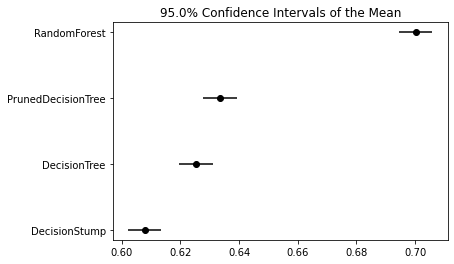

In [6]:
# Task 3: 
random_seed = 1234

train_prunedDecisionTree = []
train_decisionTree = []
train_decisionStump = []
train_randomForest = []

res_prunedDecisionTree = []
res_decisionTree = []
res_decisionStump = []
res_randomForest = []

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
    
    # Training the Decision Tree classifier
    decisionTree = DecisionTreeClassifier(random_state=random_seed, criterion="entropy")
    res_decisionTree.append(decisionTree.fit(X_train, y_train.ravel()).score(X_test, y_test.ravel()))
    train_decisionTree.append(decisionTree.fit(X_train, y_train.ravel()).score(X_train, y_train.ravel()))
    
    # Training the Random Forest classifier
    randomForest = RandomForestClassifier(random_state=random_seed, criterion="entropy")
    res_randomForest.append(randomForest.fit(X_train, y_train.ravel()).score(X_test, y_test.ravel()))
    train_randomForest.append(randomForest.fit(X_train, y_train.ravel()).score(X_train, y_train.ravel()))
    
    # Training the Decision Stump classifier
    decisionStump = DecisionTreeClassifier(random_state=random_seed, criterion="entropy", max_depth=1)
    res_decisionStump.append(decisionStump.fit(X_train, y_train.ravel()).score(X_test, y_test.ravel()))
    train_decisionStump.append(decisionStump.fit(X_train, y_train.ravel()).score(X_train, y_train.ravel()))
    
    # Training the Pruned Decision Tree classifier
    X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_seed)
    decisionTree = DecisionTreeClassifier(random_state=random_seed, criterion="entropy")
    decisionTree.fit(X_train_, y_train_.ravel())
    path = decisionTree.cost_complexity_pruning_path(X_train_, y_train_)
    alphas = path['ccp_alphas']
    predictionAccuracy = []
    
    for i in alphas:
        prunedDecisionTree = DecisionTreeClassifier(ccp_alpha=i, random_state=random_seed).fit(X_train_, y_train_)
        y_prediction = prunedDecisionTree.predict(X_val)
        predictionAccuracy.append(accuracy_score(y_val, y_prediction))
        
    maximumTestAccuracyAlpha = path.ccp_alphas[np.argmax(predictionAccuracy)]
    prunedDecisionTree = DecisionTreeClassifier(random_state=random_seed, ccp_alpha=maximumTestAccuracyAlpha, criterion="entropy")
    res_prunedDecisionTree.append(prunedDecisionTree.fit(X_train, y_train.ravel()).score(X_test, y_test.ravel()))
    train_prunedDecisionTree.append(prunedDecisionTree.fit(X_train, y_train.ravel()).score(X_train, y_train.ravel()))
    
    # Generate a new random seed
    random_seed += 999

print('Decision Tree train accuracy: {:.2f}%'.format(np.mean(train_decisionTree)*100))
print('Decision Stump train accuracy: {:.2f}%'.format(np.mean(train_decisionStump)*100))
print('Random Forest train accuracy: {:.2f}%'.format(np.mean(train_randomForest)*100))
print('Pruned Decision Tree train accuracy: {:.2f}%'.format(np.mean(train_prunedDecisionTree)*100))    
print('\n')
    
print('Decision Tree test accuracy: {:.2f}%'.format(np.mean(res_decisionTree)*100))
print('Decision Stump test accuracy: {:.2f}%'.format(np.mean(res_decisionStump)*100))
print('Random Forest test accuracy: {:.2f}%'.format(np.mean(res_randomForest)*100))
print('Pruned Decision Tree test accuracy: {:.2f}%'.format(np.mean(res_prunedDecisionTree)*100))
print('\n')

x = {'DecisionTree':res_decisionTree,
     'RandomForest':res_randomForest,
     'DecisionStump':res_decisionStump,
     'PrunedDecisionTree': res_prunedDecisionTree,
    }

df = pd.DataFrame (x, columns = ['DecisionTree','RandomForest','DecisionStump','PrunedDecisionTree'])
print(df)
result = autorank(df, verbose=False)
print(result)
create_report(result)
plot_stats(result)



# Task 4 [Results with 20% normal additive noise] 

After adding 20% additive noise to the features, we achieve the following results:  
  
Decision Tree train accuracy: 100.00%
Decision Stump train accuracy: 61.59%
Random Forest train accuracy: 100.00%
Pruned Decision Tree train accuracy: 88.80%

Decision Tree test accuracy: 61.96% with a standard deviation of 3.44%  
Decision Stump test accuracy: 61.32% with a standard deviation of 3.40%  
Random Forest test accuracy: 69.75% with a standard deviation of 2.92%  
Pruned Decision Tree test accuracy: 62.76% with a standard deviation of 3.56%  

To compute the noise, we call np.random.normal(mean, sd, shape) to return a (Gaussian) normally-distributed array with a standard deviation of 0.20. We then apply an addition operation between the original features and the product of the noise and mean value of the features. 

Compared to the classifiers on a clean dataset, decision stump performed marginally better (+0.54%), whereas decision tree (-0.57%), pruned decision tree (-0.69%) and random forest (-0.27%) performed marginally worse. 

Random forest is still the best performer with a 69.75% prediction accuracy on the test set. The accuracy was barely influenced by 20% additive noise which could be attributed to Random Forest being a robust classifier less influenced by noise. 

On the other hand, decision stump was the only classifer that had performed better with noise, albeit very slightly. A decision stump is a 1-level tree so predictions are made based on a single feature. The noise may have inadvertently helped create a better performing threshold for the splitting rule. 


Decision Tree train accuracy: 100.00%
Decision Stump train accuracy: 61.59%
Random Forest train accuracy: 100.00%
Pruned Decision Tree train accuracy: 88.80%


Decision Tree test accuracy: 61.96%
Decision Stump test accuracy: 61.32%
Random Forest test accuracy: 69.75%
Pruned Decision Tree test accuracy: 62.76%


    DecisionTree  RandomForest  DecisionStump  PrunedDecisionTree
0          0.635         0.690          0.650               0.640
1          0.585         0.670          0.635               0.585
2          0.610         0.685          0.615               0.595
3          0.625         0.725          0.575               0.615
4          0.610         0.690          0.595               0.600
..           ...           ...            ...                 ...
95         0.640         0.660          0.610               0.610
96         0.635         0.755          0.585               0.655
97         0.650         0.700          0.610               0.665
98         0.635         0

/Users/stephenwang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.insert(self.groupsunique.astype(str), 0, ''))


<AxesSubplot:title={'center':'95.0% Confidence Intervals of the Mean'}>

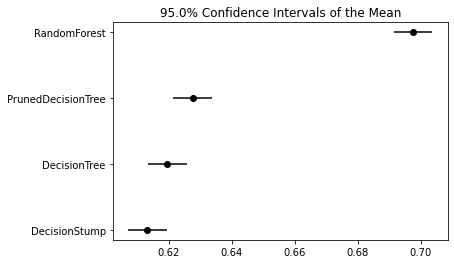

In [7]:
random = np.random.default_rng()
noise = np.random.normal(0, 0.2, np.shape(X))
X_noise = X + np.multiply(noise, np.average(X, axis=0))

random_seed = 1234

train_prunedDecisionTree = []
train_decisionTree = []
train_decisionStump = []
train_randomForest = []

res_prunedDecisionTree = []
res_decisionTree = []
res_decisionStump = []
res_randomForest = []

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X_noise, y, test_size=0.2, random_state=random_seed)
    
    # Training the Decision Tree classifier
    decisionTree = DecisionTreeClassifier(random_state=random_seed, criterion="entropy")
    res_decisionTree.append(decisionTree.fit(X_train, y_train.ravel()).score(X_test, y_test.ravel()))
    train_decisionTree.append(decisionTree.fit(X_train, y_train.ravel()).score(X_train, y_train.ravel()))
    
    # Training the Random Forest classifier
    randomForest = RandomForestClassifier(random_state=random_seed, criterion="entropy")
    res_randomForest.append(randomForest.fit(X_train, y_train.ravel()).score(X_test, y_test.ravel()))
    train_randomForest.append(randomForest.fit(X_train, y_train.ravel()).score(X_train, y_train.ravel()))
    
    # Training the Decision Stump classifier
    decisionStump = DecisionTreeClassifier(random_state=random_seed, criterion="entropy", max_depth=1)
    res_decisionStump.append(decisionStump.fit(X_train, y_train.ravel()).score(X_test, y_test.ravel()))
    train_decisionStump.append(decisionStump.fit(X_train, y_train.ravel()).score(X_train, y_train.ravel()))
    
    # Training the Pruned Decision Tree classifier
    X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_seed)
    decisionTree = DecisionTreeClassifier(random_state=random_seed, criterion="entropy")
    decisionTree.fit(X_train_, y_train_.ravel())
    path = decisionTree.cost_complexity_pruning_path(X_train_, y_train_)
    alphas = path['ccp_alphas']
    predictionAccuracy = []
    
    for i in alphas:
        prunedDecisionTree = DecisionTreeClassifier(ccp_alpha=i, random_state=random_seed).fit(X_train_, y_train_)
        y_prediction = prunedDecisionTree.predict(X_val)
        predictionAccuracy.append(accuracy_score(y_val, y_prediction))
        
    maximumTestAccuracyAlpha = path.ccp_alphas[np.argmax(predictionAccuracy)]
    prunedDecisionTree = DecisionTreeClassifier(random_state=random_seed, ccp_alpha=maximumTestAccuracyAlpha, criterion="entropy")
    res_prunedDecisionTree.append(prunedDecisionTree.fit(X_train, y_train.ravel()).score(X_test, y_test.ravel()))
    train_prunedDecisionTree.append(prunedDecisionTree.fit(X_train, y_train.ravel()).score(X_train, y_train.ravel()))
    
    # Generate a new random seed
    random_seed += 999
    
print('Decision Tree train accuracy: {:.2f}%'.format(np.mean(train_decisionTree)*100))
print('Decision Stump train accuracy: {:.2f}%'.format(np.mean(train_decisionStump)*100))
print('Random Forest train accuracy: {:.2f}%'.format(np.mean(train_randomForest)*100))
print('Pruned Decision Tree train accuracy: {:.2f}%'.format(np.mean(train_prunedDecisionTree)*100))    
print('\n')
    
print('Decision Tree test accuracy: {:.2f}%'.format(np.mean(res_decisionTree)*100))
print('Decision Stump test accuracy: {:.2f}%'.format(np.mean(res_decisionStump)*100))
print('Random Forest test accuracy: {:.2f}%'.format(np.mean(res_randomForest)*100))
print('Pruned Decision Tree test accuracy: {:.2f}%'.format(np.mean(res_prunedDecisionTree)*100))
print('\n')

x = {'DecisionTree':res_decisionTree,
     'RandomForest':res_randomForest,
     'DecisionStump':res_decisionStump,
     'PrunedDecisionTree': res_prunedDecisionTree,
    }

df = pd.DataFrame (x, columns = ['DecisionTree','RandomForest','DecisionStump','PrunedDecisionTree'])
print(df)
result = autorank(df, verbose=False)
print(result)
create_report(result)
plot_stats(result)

# Task 5 [Results with 20% multiplicative noise] 

After adding 20% multiplicative noise to the features, we achieve the following results:  
Decision Tree train accuracy: 100.00%
Decision Stump train accuracy: 61.40%
Random Forest train accuracy: 100.00%
Pruned Decision Tree train accuracy: 88.28%

Decision Tree test accuracy: 61.93% with standard deviation of 3.33%  
Decision Stump test accuracy: 58.41% with standard deviation of 3.13%  
Random Forest test accuracy: 68.33% with standard deviation of 2.89%  
Pruned Decision Tree test accuracy: 63.23% with standard deviation of 3.49%  

Rather than adding the features and product of the noise and the mean value of the features together to insert additive noise, we multiply our features with the normally-distributed array returned from the np.random.normal() method.

Compared to the classifiers on a clean dataset, decision stump (-2.37%), decision tree (-0.60%), pruned decision tree (-1.69%) and random forest (-0.13%) all performed worse.

Difference between additive and multiplicative noise impact?  
We observe a more severe influence on the prediction accuracy of the decision stump and pruned decision tree with multiplicative noise compared to additive noise, but having roughly the same effect for decision trees and random forest. 


Decision Tree train accuracy: 100.00%
Decision Stump train accuracy: 61.40%
Random Forest train accuracy: 100.00%
Pruned Decision Tree train accuracy: 88.28%


Decision Tree test accuracy: 61.93%
Decision Stump test accuracy: 58.41%
Random Forest test accuracy: 68.33%
Pruned Decision Tree test accuracy: 63.23%


    DecisionTree  RandomForest  DecisionStump  PrunedDecisionTree
0          0.600         0.685          0.615               0.670
1          0.640         0.670          0.610               0.640
2          0.595         0.655          0.605               0.605
3          0.635         0.685          0.545               0.625
4          0.695         0.700          0.575               0.690
..           ...           ...            ...                 ...
95         0.610         0.640          0.585               0.625
96         0.670         0.735          0.570               0.715
97         0.665         0.700          0.610               0.700
98         0.590         0

/Users/stephenwang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.insert(self.groupsunique.astype(str), 0, ''))


<AxesSubplot:title={'center':'95.0% Confidence Intervals of the Mean'}>

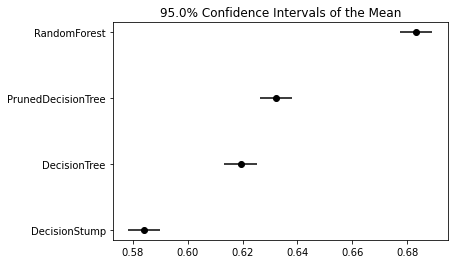

In [8]:
# Task 5 multiplicative noise 
noise = np.random.normal(1, 0.2, np.shape(X))
X_noise = np.multiply(X, noise)

random_seed = 1234

train_prunedDecisionTree = []
train_decisionTree = []
train_decisionStump = []
train_randomForest = []

res_prunedDecisionTree = []
res_decisionTree = []
res_decisionStump = []
res_randomForest = []

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X_noise, y, test_size=0.2, random_state=random_seed)
    
    # Training the Decision Tree classifier
    decisionTree = DecisionTreeClassifier(random_state=random_seed, criterion="entropy")
    res_decisionTree.append(decisionTree.fit(X_train, y_train.ravel()).score(X_test, y_test.ravel()))
    train_decisionTree.append(decisionTree.fit(X_train, y_train.ravel()).score(X_train, y_train.ravel()))
    
    # Training the Random Forest classifier
    randomForest = RandomForestClassifier(random_state=random_seed, criterion="entropy")
    res_randomForest.append(randomForest.fit(X_train, y_train.ravel()).score(X_test, y_test.ravel()))
    train_randomForest.append(randomForest.fit(X_train, y_train.ravel()).score(X_train, y_train.ravel()))
    
    # Training the Decision Stump classifier
    decisionStump = DecisionTreeClassifier(random_state=random_seed, criterion="entropy", max_depth=1)
    res_decisionStump.append(decisionStump.fit(X_train, y_train.ravel()).score(X_test, y_test.ravel()))
    train_decisionStump.append(decisionStump.fit(X_train, y_train.ravel()).score(X_train, y_train.ravel()))
    
    # Training the Pruned Decision Tree classifier
    X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_seed)
    decisionTree = DecisionTreeClassifier(random_state=random_seed, criterion="entropy")
    decisionTree.fit(X_train_, y_train_.ravel())
    path = decisionTree.cost_complexity_pruning_path(X_train_, y_train_)
    alphas = path['ccp_alphas']
    predictionAccuracy = []
    
    for i in alphas:
        prunedDecisionTree = DecisionTreeClassifier(ccp_alpha=i, random_state=random_seed).fit(X_train_, y_train_)
        y_prediction = prunedDecisionTree.predict(X_val)
        predictionAccuracy.append(accuracy_score(y_val, y_prediction))
        
    maximumTestAccuracyAlpha = path.ccp_alphas[np.argmax(predictionAccuracy)]
    prunedDecisionTree = DecisionTreeClassifier(random_state=random_seed, ccp_alpha=maximumTestAccuracyAlpha, criterion="entropy")
    res_prunedDecisionTree.append(prunedDecisionTree.fit(X_train, y_train.ravel()).score(X_test, y_test.ravel()))
    train_prunedDecisionTree.append(prunedDecisionTree.fit(X_train, y_train.ravel()).score(X_train, y_train.ravel()))
    
    # Generate a new random seed
    random_seed += 999
    
print('Decision Tree train accuracy: {:.2f}%'.format(np.mean(train_decisionTree)*100))
print('Decision Stump train accuracy: {:.2f}%'.format(np.mean(train_decisionStump)*100))
print('Random Forest train accuracy: {:.2f}%'.format(np.mean(train_randomForest)*100))
print('Pruned Decision Tree train accuracy: {:.2f}%'.format(np.mean(train_prunedDecisionTree)*100))    
print('\n')
    
print('Decision Tree test accuracy: {:.2f}%'.format(np.mean(res_decisionTree)*100))
print('Decision Stump test accuracy: {:.2f}%'.format(np.mean(res_decisionStump)*100))
print('Random Forest test accuracy: {:.2f}%'.format(np.mean(res_randomForest)*100))
print('Pruned Decision Tree test accuracy: {:.2f}%'.format(np.mean(res_prunedDecisionTree)*100))
print('\n')

x = {'DecisionTree':res_decisionTree,
     'RandomForest':res_randomForest,
     'DecisionStump':res_decisionStump,
     'PrunedDecisionTree': res_prunedDecisionTree,
    }

df = pd.DataFrame (x, columns = ['DecisionTree','RandomForest','DecisionStump','PrunedDecisionTree'])
print(df)
result = autorank(df, verbose=False)
print(result)
create_report(result)
plot_stats(result)

# Task 6 [Results with 5% class noise] 

After adding 5% class noise, we achieve the following results:  
Decision Tree train accuracy: 100.00%  
Decision Stump train accuracy: 60.75%  
Random Forest train accuracy: 100.00%  
Pruned Decision Tree train accuracy: 85.70%  
  
Decision Tree test accuracy: 58.92%  
Decision Stump test accuracy: 56.26%  
Random Forest test accuracy: 65.95%  
Pruned Decision Tree test accuracy: 59.97%  

Class noise had a larger negative effect on the performance of the classifiers than feature noise. Compared to the performance of the classifiers on a clean dataset, decision stump (-4.52%), decision tree (-3.61%), pruned decision tree (-3.38%) and random forest (-4.07%) all performed worse. An interesting observation to be made, is that the performance worsened closer to the degree of class noise (5%) compared to when we observed the impact of adding n degree of feature noise.

We can attribute the difference in impact between class noise and feature noise on the classifiers due to the following properties:  
(1) each instance/row has multiple features but only one label which, if noisy, distorts the regular pattern required for prediction, and  
(2) robust classifiers, like RandomForest, have strategies to handle noisy features but not so much class noise.


In [9]:
y = y.ravel()
flip = random.binomial(1, 0.05, y.shape).astype(bool)
y_flipped = np.where(flip, 1 - y, y)
# print(y)
# print(y_flipped)
# print(np.c_[y, y_flipped][flip])

Decision Tree train accuracy: 100.00%
Decision Stump train accuracy: 61.02%
Random Forest train accuracy: 100.00%
Pruned Decision Tree train accuracy: 85.33%


Decision Tree test accuracy: 58.72%
Decision Stump test accuracy: 56.90%
Random Forest test accuracy: 65.05%
Pruned Decision Tree test accuracy: 60.03%


    DecisionTree  RandomForest  DecisionStump  PrunedDecisionTree
0          0.570         0.640          0.595               0.630
1          0.600         0.695          0.625               0.615
2          0.615         0.630          0.590               0.620
3          0.600         0.640          0.545               0.600
4          0.550         0.640          0.565               0.635
..           ...           ...            ...                 ...
95         0.595         0.660          0.575               0.630
96         0.650         0.710          0.585               0.650
97         0.600         0.655          0.590               0.670
98         0.600         0

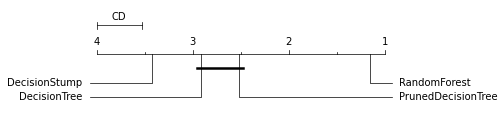

In [10]:
random_seed = 1234

train_prunedDecisionTree = []
train_decisionTree = []
train_decisionStump = []
train_randomForest = []

res_prunedDecisionTree = []
res_decisionTree = []
res_decisionStump = []
res_randomForest = []

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X_noise, y_flipped, test_size=0.2, random_state=random_seed)
    
    # Training the Decision Tree classifier
    decisionTree = DecisionTreeClassifier(random_state=random_seed, criterion="entropy")
    res_decisionTree.append(decisionTree.fit(X_train, y_train.ravel()).score(X_test, y_test.ravel()))
    train_decisionTree.append(decisionTree.fit(X_train, y_train.ravel()).score(X_train, y_train.ravel()))
    
    # Training the Random Forest classifier
    randomForest = RandomForestClassifier(random_state=random_seed, criterion="entropy")
    res_randomForest.append(randomForest.fit(X_train, y_train.ravel()).score(X_test, y_test.ravel()))
    train_randomForest.append(randomForest.fit(X_train, y_train.ravel()).score(X_train, y_train.ravel()))
    
    # Training the Decision Stump classifier
    decisionStump = DecisionTreeClassifier(random_state=random_seed, criterion="entropy", max_depth=1)
    res_decisionStump.append(decisionStump.fit(X_train, y_train.ravel()).score(X_test, y_test.ravel()))
    train_decisionStump.append(decisionStump.fit(X_train, y_train.ravel()).score(X_train, y_train.ravel()))
    
    # Training the Pruned Decision Tree classifier
    X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_seed)
    decisionTree = DecisionTreeClassifier(random_state=random_seed, criterion="entropy")
    decisionTree.fit(X_train_, y_train_.ravel())
    path = decisionTree.cost_complexity_pruning_path(X_train_, y_train_)
    alphas = path['ccp_alphas']
    predictionAccuracy = []
    
    for i in alphas:
        prunedDecisionTree = DecisionTreeClassifier(ccp_alpha=i, random_state=random_seed).fit(X_train_, y_train_)
        y_prediction = prunedDecisionTree.predict(X_val)
        predictionAccuracy.append(accuracy_score(y_val, y_prediction))
        
    maximumTestAccuracyAlpha = path.ccp_alphas[np.argmax(predictionAccuracy)]
    prunedDecisionTree = DecisionTreeClassifier(random_state=random_seed, ccp_alpha=maximumTestAccuracyAlpha, criterion="entropy")
    res_prunedDecisionTree.append(prunedDecisionTree.fit(X_train, y_train.ravel()).score(X_test, y_test.ravel()))
    train_prunedDecisionTree.append(prunedDecisionTree.fit(X_train, y_train.ravel()).score(X_train, y_train.ravel()))
    
    # Generate a new random seed
    random_seed += 999
    
print('Decision Tree train accuracy: {:.2f}%'.format(np.mean(train_decisionTree)*100))
print('Decision Stump train accuracy: {:.2f}%'.format(np.mean(train_decisionStump)*100))
print('Random Forest train accuracy: {:.2f}%'.format(np.mean(train_randomForest)*100))
print('Pruned Decision Tree train accuracy: {:.2f}%'.format(np.mean(train_prunedDecisionTree)*100))    
print('\n')
    
print('Decision Tree test accuracy: {:.2f}%'.format(np.mean(res_decisionTree)*100))
print('Decision Stump test accuracy: {:.2f}%'.format(np.mean(res_decisionStump)*100))
print('Random Forest test accuracy: {:.2f}%'.format(np.mean(res_randomForest)*100))
print('Pruned Decision Tree test accuracy: {:.2f}%'.format(np.mean(res_prunedDecisionTree)*100))
print('\n')

x = {'DecisionTree':res_decisionTree,
     'RandomForest':res_randomForest,
     'DecisionStump':res_decisionStump,
     'PrunedDecisionTree': res_prunedDecisionTree,
    }

df = pd.DataFrame (x, columns = ['DecisionTree','RandomForest','DecisionStump','PrunedDecisionTree'])
print(df)
result = autorank(df, verbose=False)
print(result)
create_report(result)
plot_stats(result)

# Task 7 

After adding 20% multiplicative noise to the training set:  
Decision Tree test accuracy: 62.27%  
Decision Stump test accuracy: 60.28%  
Random Forest test accuracy: 69.18%  
Pruned Decision Tree test accuracy: 63.38%  

After adding 20% multiplicative noise to the test set:  
Decision Tree accuracy: 62.10%  
Decision Stump accuracy: 60.40%  
Random Forest accuracy: 69.45%  
Pruned Decision Tree accuracy: 63.09%  

The two results are so marginally different, therefore we can conclude there is neglible difference to the classifier performance by adding 20% multiplicative noise to the training set or the test set after splitting the dataset. 

Decision Tree accuracy: 62.27%
Decision Stump accuracy: 60.28%
Random Forest accuracy: 69.18%
Pruned Decision Tree accuracy: 63.38%
    DecisionTree  RandomForest  DecisionStump  PrunedDecisionTree
0          0.600         0.700          0.635               0.585
1          0.640         0.655          0.615               0.690
2          0.655         0.695          0.600               0.660
3          0.595         0.715          0.575               0.630
4          0.635         0.690          0.610               0.665
..           ...           ...            ...                 ...
95         0.640         0.690          0.610               0.635
96         0.640         0.725          0.590               0.635
97         0.590         0.715          0.625               0.595
98         0.640         0.675          0.575               0.630
99         0.585         0.715          0.610               0.580

[100 rows x 4 columns]
RankResult(rankdf=
                    meanrank     

/Users/stephenwang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.insert(self.groupsunique.astype(str), 0, ''))


<AxesSubplot:title={'center':'95.0% Confidence Intervals of the Mean'}>

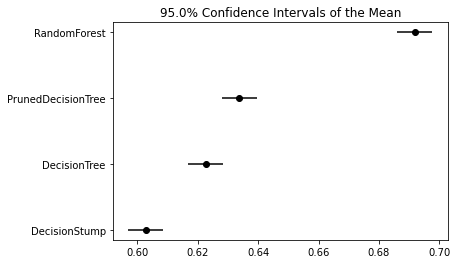

In [11]:
# Task 7
random_seed = 1234
res_prunedDecisionTree = []
res_decisionTree = []
res_decisionStump = []
res_randomForest = []

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
    noise = np.random.normal(1, 0.2, np.shape(X_train))
    X_train_noise = np.multiply(X_train, noise)
    
    # Training the Decision Tree classifier
    decisionTree = DecisionTreeClassifier(random_state=random_seed, criterion="entropy")
    res_decisionTree.append(decisionTree.fit(X_train_noise, y_train.ravel()).score(X_test, y_test.ravel()))
    
    # Training the Random Forest classifier
    randomForest = RandomForestClassifier(random_state=random_seed, criterion="entropy")
    res_randomForest.append(randomForest.fit(X_train_noise, y_train.ravel()).score(X_test, y_test.ravel()))
    
    # Training the Decision Stump classifier
    decisionStump = DecisionTreeClassifier(random_state=random_seed, criterion="entropy", max_depth=1)
    res_decisionStump.append(decisionStump.fit(X_train_noise, y_train.ravel()).score(X_test, y_test.ravel()))
    
    # Training the Pruned Decision Tree classifier
    X_train_, X_val, y_train_, y_val = train_test_split(X_train_noise, y_train, test_size=0.2, random_state=random_seed)
    decisionTree = DecisionTreeClassifier(random_state=random_seed, criterion="entropy")
    decisionTree.fit(X_train_, y_train_.ravel())
    path = decisionTree.cost_complexity_pruning_path(X_train_, y_train_)
    alphas = path['ccp_alphas']
    predictionAccuracy = []
    
    for i in alphas:
        prunedDecisionTree = DecisionTreeClassifier(ccp_alpha=i, random_state=random_seed).fit(X_train_, y_train_)
        y_prediction = prunedDecisionTree.predict(X_val)
        predictionAccuracy.append(accuracy_score(y_val, y_prediction))
        
    maximumTestAccuracyAlpha = path.ccp_alphas[np.argmax(predictionAccuracy)]
    prunedDecisionTree = DecisionTreeClassifier(random_state=random_seed, ccp_alpha=maximumTestAccuracyAlpha, criterion="entropy")
    res_prunedDecisionTree.append(prunedDecisionTree.fit(X_train_noise, y_train.ravel()).score(X_test, y_test.ravel()))
    train_prunedDecisionTree.append(prunedDecisionTree.fit(X_train_noise, y_train.ravel()).score(X_train, y_train.ravel()))
    
    # Generate a new random seed
    random_seed += 999

print('Decision Tree accuracy: {:.2f}%'.format(np.mean(res_decisionTree)*100))
print('Decision Stump accuracy: {:.2f}%'.format(np.mean(res_decisionStump)*100))
print('Random Forest accuracy: {:.2f}%'.format(np.mean(res_randomForest)*100))
print('Pruned Decision Tree accuracy: {:.2f}%'.format(np.mean(res_prunedDecisionTree)*100))

x = {'DecisionTree':res_decisionTree,
     'RandomForest':res_randomForest,
     'DecisionStump':res_decisionStump,
     'PrunedDecisionTree': res_prunedDecisionTree,
    }

df = pd.DataFrame (x, columns = ['DecisionTree','RandomForest','DecisionStump','PrunedDecisionTree'])
print(df)
result = autorank(df, verbose=False)
print(result)
create_report(result)
plot_stats(result)
    
    

Decision Tree accuracy: 62.10%
Decision Stump accuracy: 60.40%
Random Forest accuracy: 69.45%
Pruned Decision Tree accuracy: 63.09%


    DecisionTree  RandomForest  DecisionStump  PrunedDecisionTree
0          0.600         0.655          0.660               0.605
1          0.650         0.700          0.640               0.650
2          0.680         0.655          0.610               0.655
3          0.605         0.705          0.565               0.615
4          0.585         0.720          0.580               0.635
..           ...           ...            ...                 ...
95         0.605         0.675          0.595               0.625
96         0.640         0.740          0.570               0.700
97         0.640         0.710          0.625               0.640
98         0.650         0.690          0.550               0.650
99         0.645         0.725          0.635               0.675

[100 rows x 4 columns]
RankResult(rankdf=
                    meanrank   

/Users/stephenwang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.insert(self.groupsunique.astype(str), 0, ''))


<AxesSubplot:title={'center':'95.0% Confidence Intervals of the Mean'}>

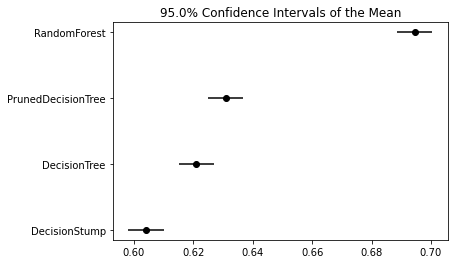

In [12]:
# Task 7 

random_seed = 1234
res_prunedDecisionTree = []
res_decisionTree = []
res_decisionStump = []
res_randomForest = []

for i in range(100):
    # X_train, X_test, y_train, y_test = train_test_split(X_noise, y, test_size=0.2, random_state=random_seed)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
    noise = np.random.normal(1, 0.2, np.shape(X_test))
    X_test_noise = np.multiply(X_test, noise)
    
    # Training the Decision Tree classifier
    decisionTree = DecisionTreeClassifier(random_state=random_seed, criterion="entropy")
    res_decisionTree.append(decisionTree.fit(X_train, y_train.ravel()).score(X_test_noise, y_test.ravel()))
    
    # Training the Random Forest classifier
    randomForest = RandomForestClassifier(random_state=random_seed, criterion="entropy")
    res_randomForest.append(randomForest.fit(X_train, y_train.ravel()).score(X_test_noise, y_test.ravel()))
    
    # Training the Decision Stump classifier
    decisionStump = DecisionTreeClassifier(random_state=random_seed, criterion="entropy", max_depth=1)
    res_decisionStump.append(decisionStump.fit(X_train, y_train.ravel()).score(X_test_noise, y_test.ravel()))
    
    # Training the Pruned Decision Tree classifier
    X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_seed)
    decisionTree = DecisionTreeClassifier(random_state=random_seed, criterion="entropy")
    decisionTree.fit(X_train_, y_train_.ravel())
    path = decisionTree.cost_complexity_pruning_path(X_train_, y_train_)
    alphas = path['ccp_alphas']
    predictionAccuracy = []
    
    for i in alphas:
        prunedDecisionTree = DecisionTreeClassifier(ccp_alpha=i, random_state=random_seed).fit(X_train_, y_train_)
        y_prediction = prunedDecisionTree.predict(X_val)
        predictionAccuracy.append(accuracy_score(y_val, y_prediction))
        
    maximumTestAccuracyAlpha = path.ccp_alphas[np.argmax(predictionAccuracy)]
    prunedDecisionTree = DecisionTreeClassifier(random_state=random_seed, ccp_alpha=maximumTestAccuracyAlpha, criterion="entropy")
    res_prunedDecisionTree.append(prunedDecisionTree.fit(X_train, y_train.ravel()).score(X_test_noise, y_test.ravel()))
    train_prunedDecisionTree.append(prunedDecisionTree.fit(X_train, y_train.ravel()).score(X_train, y_train.ravel()))
    
    # Generate a new random seed
    random_seed += 999

print('Decision Tree accuracy: {:.2f}%'.format(np.mean(res_decisionTree)*100))
print('Decision Stump accuracy: {:.2f}%'.format(np.mean(res_decisionStump)*100))
print('Random Forest accuracy: {:.2f}%'.format(np.mean(res_randomForest)*100))
print('Pruned Decision Tree accuracy: {:.2f}%'.format(np.mean(res_prunedDecisionTree)*100))
print('\n')

x = {'DecisionTree':res_decisionTree,
     'RandomForest':res_randomForest,
     'DecisionStump':res_decisionStump,
     'PrunedDecisionTree': res_prunedDecisionTree,
    }

df = pd.DataFrame (x, columns = ['DecisionTree','RandomForest','DecisionStump','PrunedDecisionTree'])
print(df)
result = autorank(df, verbose=False)
print(result)
create_report(result)
plot_stats(result)
    